#발의안 데이터

In [3]:
"""
1. law: 발의안 데이터
law 데이터는 신설, 삭제, 키워드, 신설법안여부, 수정정도, 대주제, 소주제, 발의안 유사도, 관련논문수까지 포함

2. name_df : 국회의원 데이터

3. name_dict : 국회의원별 발의안 키워드 데이터 (클러스터링에 활용)

신설, 삭제, 수정정도, 관련논문수 -> 크롤링
키워드 -> LDA
신설법안여부 -> 개정법률안이 아닌 것 필터링
대주제 -> Ko-Bert
소주제 -> KPF-BERT
유사도 -> Doc2Vec

"""
import pandas as pd

law = pd.read_csv("발의안데이터.csv")
law.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
law.head()

,의안번호,법률안명,대표발의자,공동발의자,소관위,제안일,본회의심의결과,내용,신설,삭제,키워드,신설법안여부,수정정도,대주제,소주제,유사도,관련논문수
0,2024996,집합건물의 소유 및 관리에 관한 법률 일부개정법률안,김병관,"고용진,김병욱,김철민,박재호,박정,서형수,심기준,위성곤,유승희,이규희,이원욱,홍익표",법제사법위원회,2020-05-22,임기만료폐기,아파트 등 공동주택은 공동주택관리법에 의해 체계적으로 관리되고 있는 반면 주상복합상...,9,0,관리 주택 건물 복합 집합 오피스텔 주상 아파트 공동 발생,0,9,경제,부동산,0.368688,38
1,2024995,지방세법 일부개정법률안,김병관,"김철민,박재호,서형수,심기준,위성곤,유승희,이규희,이원욱,이종걸",행정안전위원회,2020-05-22,임기만료폐기,현행법상 아파트 등 주택에 대한 재산세 과세표준은 국토교통부가 해마다 부동산 가격공...,0,0,재산세 주택 가격 부동산 공정 시장 비율 가액 예측 부과,0,0,경제,부동산,0.275320,14
2,2024933,상장회사법안,채이배,"김관영,김동철,김종훈,박선숙,박찬대,이용득,이철희,정인화,추혜선",정무위원회,2020-05-18,임기만료폐기,상장회사에 적용되는 각종 법령은 현재 주식회사에 관한 일반법인 상법과 자본시장과 금...,55,0,임원 이사 사외 배당 회사 주주 강화 정책 사회 이익,1,55,경제,산업_기업,0.337603,0
3,2024932,자원의 절약과 재활용촉진에 관한 법률 일부개정법률안,문진국,"강석호,강효상,김규환,김명연,김석기,김용태,민경욱,이철규,정갑윤,정운천",환경노동위원회,2020-05-12,임기만료폐기,우리나라 재활용시장은 영세업체 비중이 높아 유가원자재 가격 변동 등 시장 충격에 취...,1,0,활용 시장 안정 폐기물 수거 업체 거부 가격 수도 생활,0,1,경제,자원,0.039483,110
4,2024931,건설기술 진흥법 일부개정법률안,송석준,"김석기,김정재,성일종,송언석,송희경,유동수,윤종필,이양수,이종배,함진규",국토교통위원회,2020-05-11,임기만료폐기,최근 이천시 물류센터 화재로 48명의 사상자사망 38명 중상 8명 경상 2명가 발생...,2,0,발생 위험 작업자 공사 현장 사고 공사장 실정 공간 상황,0,2,사회,사회일반,0.262229,7


In [5]:
# 발의안 데이터 대주제 table
law["대주제"].value_counts()

,count
대주제,
사회,1413
경제,833
정치,700
문화,227
IT과학,173


**KoBert와 전이학습**으로 사회, 경제, 정치, 문화, IT과학 총 5가지 대주제로 분류된 것을 확인할 수 있음

In [6]:
# 발의안 데이터 소주제 table
law["소주제"].value_counts()

,count
소주제,
사회일반,413
교육_시험,234
경제일반,231
환경,227
산업_기업,216
의료_건강,210
행정_자치,198
국회_정당,160
노동_복지,148


KPF-Bert를 통한 소주제 매칭(**미디어 제외된 데이터**)

# 발의안데이터로 **국회의원 데이터** 생성

##클러스터링

In [7]:
#20대 국회의원 명단, ㄱ~ㅎ
name_list = ['강길부', '강병원', '강석진', '강석호', '강창일', '강효상', '강훈식', '경대수', '고용진', '곽대훈', '곽상도', '권미혁', '권석창', '권성동', '권은희', '권칠승', '금태섭', '기동민', '김경수', '김경진', '김경협', '김관영', '김광림', '김광수', '김규환', '김기선', '김도읍', '김동철', '김두관', '김명연', '김무성', '김민기', '김병관', '김병기', '김병욱', '김부겸', '김삼화', '김상훈', '김상희', '김석기', '김선동', '김성수', '김성식', '김성원', '김성찬', '김성태', '김성태', '김성환', '김세연', '김수민', '김순례', '김승희', '김영우', '김영주', '김영진', '김영춘', '김영호', '김용태', '김재경', '김재원', '김정우', '김정재', '김정호', '김정훈', '김종대', '김종민', '김종석', '김종인', '김종회', '김종훈', '김중로', '김진태', '김진표', '김철민', '김태년', '김태흠', '김학용', '김한정', '김한표', '김해영', '김현권', '김현미', '김현아', '나경원', '남인순', '노웅래', '노회찬', '도종환', '맹성규', '문미옥', '문진국', '문희상', '민경욱', '민병두', '민홍철', '박경미', '박광온', '박남춘', '박대출', '박덕흠', '박맹우', '박명재', '박범계', '박병석', '박선숙', '박성중', '박순자', '박영선', '박완수', '박완주', '박용진', '박인숙', '박재호', '박정', '박주민', '박주선', '박주현', '박준영', '박지원', '박찬대', '박찬우', '박홍근', '배덕광', '백승주', '백재현', '백혜련', '변재일', '서삼석', '서영교', '서청원', '서형수', '설훈', '성일종', '소병훈', '손금주', '손혜원', '송갑석', '송기석', '송기헌', '송석준', '송언석', '송영길', '송옥주', '송희경', '신경민', '신동근', '신보라', '신상진', '신용현', '신창현', '심기준', '심상정', '심재권', '심재철', '안규백', '안민석', '안상수', '안철수', '안호영', '양승조', '어기구', '엄용수', '여상규', '여영국', '염동열', '오세정', '오신환', '오영훈', '오제세', '우상호', '우원식', '원유철', '원혜영', '위성곤', '유기준', '유동수', '유민봉', '유성엽', '유승민', '유승희', '유은혜', '유의동', '유재중', '윤관석', '윤상직', '윤상현', '윤소하', '윤영석', '윤영일', '윤일규', '윤재옥', '윤종오', '윤종필', '윤준호', '윤한홍', '윤호중', '윤후덕', '이개호', '이군현', '이규희', '이동섭', '이만희', '이명수', '이상돈', '이상민', '이상헌', '이석현', '이수혁', '이양수', '이언주', '이완영', '이용득', '이용주', '이용호', '이우현', '이원욱', '이은권', '이은재', '이인영', '이장우', '이재정', '이정미', '이정현', '이종걸', '이종구', '이종명', '이종배', '이주영', '이진복', '이찬열', '이채익', '이철규', '이철우', '이철희', '이춘석', '이태규', '이학영', '이학재', '이해찬', '이헌승', '이현재', '이혜훈', '이후삼', '이훈', '인재근', '임이자', '임재훈', '임종성', '장병완', '장석춘', '장정숙', '장제원', '전재수', '전해철', '전현희', '전혜숙', '전희경', '정갑윤', '정동영', '정병국', '정성호', '정세균', '정양석', '정용기', '정우택', '정운천', '정유섭', '정은혜', '정인화', '정재호', '정점식', '정종섭', '정진석', '정춘숙', '정태옥', '제윤경', '조경태', '조배숙', '조승래', '조원진', '조응천', '조정식', '조훈현', '주광덕', '주승용', '주호영', '지상욱', '진선미', '진영', '채이배', '천정배', '최경환', '최경환', '최교일', '최도자', '최명길', '최연혜', '최운열', '최인호', '최재성', '추경호', '추미애', '추혜선', '표창원', '하태경', '한선교', '한정애', '함진규', '허윤정', '홍문종', '홍문표', '홍영표', '홍의락', '홍익표', '홍일표', '홍철호', '황영철', '황주홍', '황희']

# 국회의원 데이터프레임 생성
name_df = pd.DataFrame(name_list, columns = ['국회의원명'])

# 클러스터링을 위해 국회의원 별 키워드 할당할 dict 생성(리스트에 발의안 키워드 할당)
name_dict = {name: [] for name in name_list}

#국회의원 딕셔너리에 해당 국회의원이 발의한 발의안의 키워드 할당
for i in range(len(name_df)):
    name = name_df.loc[i, '국회의원명']
    for j in range(len(law)):
        if (name == law.loc[j, '대표발의자']) or (name in law.loc[j, '공동발의자']) :
        #if (name == comm.loc[j, '대표발의자']):
            content = str(law.loc[j, '키워드'])
            name_dict[name].append(content)
        else:
          continue

In [8]:
# 국회의원당 발의안 키워드가 value값으로 잘 들어감
name_dict['강길부'][:5]

['인력 전문 양성 벤처 도자 기업부 시설 장관 단체 연구소',
 '규모 조사 타당성 예비 도입 투자 확보 이상 대상 기준',
 '강화 전부 종류 대상 불문 국가 주체 외의 책임 명시',
 '어린이 이상 버스 운전자 통학 실시 결과 채용 운전 통보',
 '주기 시의 실제 정책 조사 수립 기초 자료 청소년 학교']

In [9]:
!pip install --upgrade transformers
!pip install konlpy

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import re

# 텍스트 전처리 함수
def preprocess_text(text):
    return re.sub(r'\s+', ' ', text).strip()

# 텍스트 벡터화 함수
def vectorize(documents):
    processed_docs = [preprocess_text(doc) for doc in documents]
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(processed_docs)
    return X, vectorizer

# 최적의 클러스터 수 탐색 함수
def find_elbow_point(X):
    inertias = []
    max_clusters = min(10, len(X.toarray()))  # 최대 클러스터 수를 10개로 제한
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    # Elbow Point 찾기
    deltas = np.diff(inertias, 2)  # 이너셔의 2차 차분을 계산하여 변화량 파악
    if len(deltas) > 0:
        elbow_point = np.argmax(deltas) + 2  # 변화량이 가장 큰 지점의 클러스터 수
    else:
        elbow_point = 2  # 클러스터 수가 2 이하인 경우 2로 설정

    return elbow_point

def cluster(documents):
    X, vectorizer = vectorize(documents)  # vectorize() 함수에서 반환된 X와 vectorizer 객체를 튜플로 받음
    best_n_clusters = find_elbow_point(X)
    kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
    kmeans.fit(X)

    # 각 클러스터의 중심 단어 가져오기
    cluster_centers = kmeans.cluster_centers_
    feature_names = vectorizer.get_feature_names_out()  # vectorizer 객체에서 특성 이름 가져오기
    cluster_keywords = []
    for center in cluster_centers:
        top_indices = center.argsort()[-10:]  # 클러스터 중심 벡터에서 상위 10개의 인덱스 가져오기
        keywords = [feature_names[i] for i in top_indices]  # 해당 인덱스에 해당하는 단어 가져오기
        cluster_keywords.append(keywords)

    return kmeans.inertia_, cluster_keywords, best_n_clusters
    #이때 inertia는 군집 내의 거리를 의미. 국회의원은 본인이 속해있는 상임위원회가 있으므로 발의하는 큰 주제는 비슷할 것이라고 판단하여,
    #군집 간의 거리보다 군집 내의 거리가 더 중요하므로, inertia 값을 반환함

In [11]:
results = {}
for name, docs in name_dict.items():
    if len(docs) > 1:
        avg_inertia, keywords, best_n_clusters = cluster(docs)  # cluster() 함수에서 반환된 키워드를 받음
        results[name] = {'avg_inertia': avg_inertia, 'keywords': keywords}  # 결과를 딕셔너리로 저장
    else:
        results[name] = {'avg_inertia': 0, 'keywords': []} # 문서가 하나밖에 없는 경우 클러스터링 불가


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
# inertia 값 가져오기
clusturing = []

for name in name_df["국회의원명"] :
    clusturing.append(results[name]['avg_inertia'])

# 국회의원 데이터에 inertia값 할당
name_df["발의안유사도"] = clusturing

## 데이터 전치리

In [13]:
"""
1. 이상치 : 발의안이 거의 없거나 부족한 사람들은 분석시 의미가 없기 때문에 이상치로 분류 할 수 있다. 제거 후 분석.
2. 동명이인 처리 : 동명이인을 따로 처리하지 않고 모두 삭제하는 것으로 결정
"""
# 이상치 처리 (필터링)
# 발의안 유사도 0 즉, 발의안을 내지 않고 중도에 잘린 사람 필터링
name_df = name_df[name_df["발의안유사도"]!= 0]

# 발의안 을 적게 내고 중도에 잘린 사람 필터링
name_df = name_df[(name_df["국회의원명"]!= "이태규" ) & (name_df["국회의원명"]!= "황영철" ) & (name_df["국회의원명"]!= "이완영")]

# 동명이인 처리
con1 = name_df["국회의원명"] != "김성태"
con2 = name_df["국회의원명"] != "최경환"
name_df = name_df[con1 & con2]

# 처리 후 인덱스 리셋
name_df.reset_index(inplace = True, drop = True)

In [14]:
# 필터링 후 총 294명 국회의원 남음
name_df.shape

(294, 2)

In [15]:
# 대표발의안수
first = law["대표발의자"].value_counts().to_dict()

first_list = []
for value in name_df["국회의원명"] :
    try :
        first_list.append(first[value])
    except :
        first_list.append(0)

name_df["대표발의안수"] = first_list

In [16]:
# 공동발의건수
together_list = []

for value in name_df["국회의원명"] :
    try :
        count = law["공동발의자"].str.contains(value).sum()
        together_list.append(count)
    except :
        together_list.append(0)

name_df["공동발의건수"] = together_list

In [17]:
#발의안수 = 대표발의안수 + 공동발의안수
name_df["발의안수"] = name_df["대표발의안수"] + name_df["공동발의건수"]

In [18]:
# 신설조항개수
new = law.groupby("대표발의자")["신설"].sum()

new_list = []

for value in name_df["국회의원명"] :
    if value in new.index :
        new_list.append(new[value])
    else :
        new_list.append(0)

name_df["신설조항개수"] = new_list

In [19]:
# 삭제조항개수
delete = law.groupby("대표발의자")["삭제"].sum()

del_list = []

for value in name_df["국회의원명"] :
    if value in delete.index :
        del_list.append(delete[value])
    else :
        del_list.append(0)

name_df["삭제조항개수"] = del_list

In [20]:
# 신설법안개수
new_law = law.groupby("대표발의자")["신설법안여부"].sum()

new_law_list = []

for value in name_df["국회의원명"] :
    if value in new_law.index :
        new_law_list.append(new_law[value])
    else :
        new_law_list.append(0)

name_df["신설법안개수"] = new_law_list

In [21]:
# 본회의심의결과
result = law["본회의심의결과"].unique()

law_copy = law.copy()

for q in result :
    set_list = []
    for result in list(law["본회의심의결과"]) :
        if result == q :
            set_list.append(1)
        else :
            set_list.append(0)
    law_copy["{}_onehot".format(q)] = set_list

In [22]:
import numpy as np
# 대표발의자 기준으로 본회의심의결과 groupby
df_sum = law_copy.groupby('대표발의자').aggregate({"임기만료폐기_onehot": np.sum,
                                              "수정가결_onehot": np.sum,
                                              "원안가결_onehot":np.sum,
                                              "대안반영폐기_onehot":np.sum,
                                              "폐기_onehot":np.sum}).reset_index()

<ipython-input-22-6ae43a7140e0>:3: FutureWarning: The provided callable <function sum at 0x7ef7e46cae60> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_sum = law_copy.groupby('대표발의자').aggregate({"임기만료폐기_onehot": np.sum,
<ipython-input-22-6ae43a7140e0>:3: FutureWarning: The provided callable <function sum at 0x7ef7e46cae60> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_sum = law_copy.groupby('대표발의자').aggregate({"임기만료폐기_onehot": np.sum,


In [23]:
# 발의안 데이터에서 국회의원 데이터로 변환
sub1 = []
sub2 = []
sub3 = []
sub4 = []
sub5 = []

for nation in name_df["국회의원명"]:
    n = 0
    for q in df_sum["대표발의자"] :
        if nation == q :
            n += 1
            s1 = df_sum[df_sum["대표발의자"] == q ]["임기만료폐기_onehot"]
            sub1.append(int(s1))
            s2 = df_sum[df_sum["대표발의자"] == q ]["수정가결_onehot"]
            sub2.append(int(s2))
            s3 = df_sum[df_sum["대표발의자"] == q ]["원안가결_onehot"]
            sub3.append(int(s3))
            s4 = df_sum[df_sum["대표발의자"] == q ]["대안반영폐기_onehot"]
            sub4.append(int(s4))
            s5 = df_sum[df_sum["대표발의자"] == q ]["폐기_onehot"]
            sub5.append(int(s5))

    if n == 0 :
        sub1.append(0)
        sub2.append(0)
        sub3.append(0)
        sub4.append(0)
        sub5.append(0)


name_df["임기만료폐기"] = sub1
name_df["수정가결"] = sub2
name_df["원안가결"] = sub3
name_df["대안반영폐기"] = sub4
name_df["폐기"] = sub5

<ipython-input-23-6125fc3946a5>:14: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sub1.append(int(s1))
<ipython-input-23-6125fc3946a5>:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sub2.append(int(s2))
<ipython-input-23-6125fc3946a5>:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sub3.append(int(s3))
<ipython-input-23-6125fc3946a5>:20: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sub4.append(int(s4))
<ipython-input-23-6125fc3946a5>:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sub5.append(int(s5))


In [24]:
#가결수 = 수정가결 + 원안가결 + 대안반영폐기
name_df["가결수"] = name_df["수정가결"] + name_df["원안가결"] + name_df["대안반영폐기"]

In [25]:
#부결수 = 임기만료폐기 + 폐기
name_df["부결수"] = name_df["임기만료폐기"] + name_df["폐기"]

In [26]:
#가결률 = 가 / 가 + 부
name_df["가결률"] = name_df["가결수"] / name_df["발의안수"]

In [27]:
#대표발의비율
name_df["대표발의비율"] = name_df["대표발의안수"] / name_df["발의안수"]

In [28]:
#발의안평균분산도(발의안 하나당 발의안 유사도) = 발의안유사도(inertia값) / 발의안수
name_df["발의안평균분산도"] = name_df["발의안유사도"] / name_df["발의안수"]

In [29]:
#발의안점수
"""
1. law(발의안데이터)에서 pca 후 각 발의안 별로 점수
2. 국회의원별로 발의안 점수 합산
3. 합산 점수 / 대표발의수 -> 발의안점수

PPT에 넣은 표의 값과 다름. -> 발의안점수 산출 코드확인필요
"""

#국회의원별 발의안 점수 데이터 가져오기
law_score = pd.read_csv("발의안점수.csv")

name_df["발의안점수"] = law_score

In [30]:
# index 국회의원명으로 변경
name_df.set_index(keys = "국회의원명", drop = True, inplace = True)

In [31]:
# 국회의원 데이터셋
name_df.head()

,발의안유사도,대표발의안수,공동발의건수,발의안수,신설조항개수,삭제조항개수,신설법안개수,임기만료폐기,수정가결,원안가결,대안반영폐기,폐기,가결수,부결수,가결률,대표발의비율,발의안평균분산도,발의안점수
국회의원명,,,,,,,,,,,,,,,,,,
강길부,42.657324,2,51,53,20,0,1,1,0,1,0,0,1,1,0.018868,0.037736,0.804855,6.08
강병원,134.118191,17,130,147,25,1,0,12,0,0,5,0,5,12,0.034014,0.115646,0.912369,7.05
강석진,90.589166,23,125,148,56,3,2,8,4,2,9,0,15,8,0.101351,0.155405,0.612089,7.19
강석호,122.544213,11,152,163,46,6,2,6,0,0,5,0,5,6,0.030675,0.067485,0.751805,7.13
강창일,112.343991,13,107,120,34,2,0,10,1,0,2,0,3,10,0.025000,0.108333,0.936200,7.04


##EDA

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


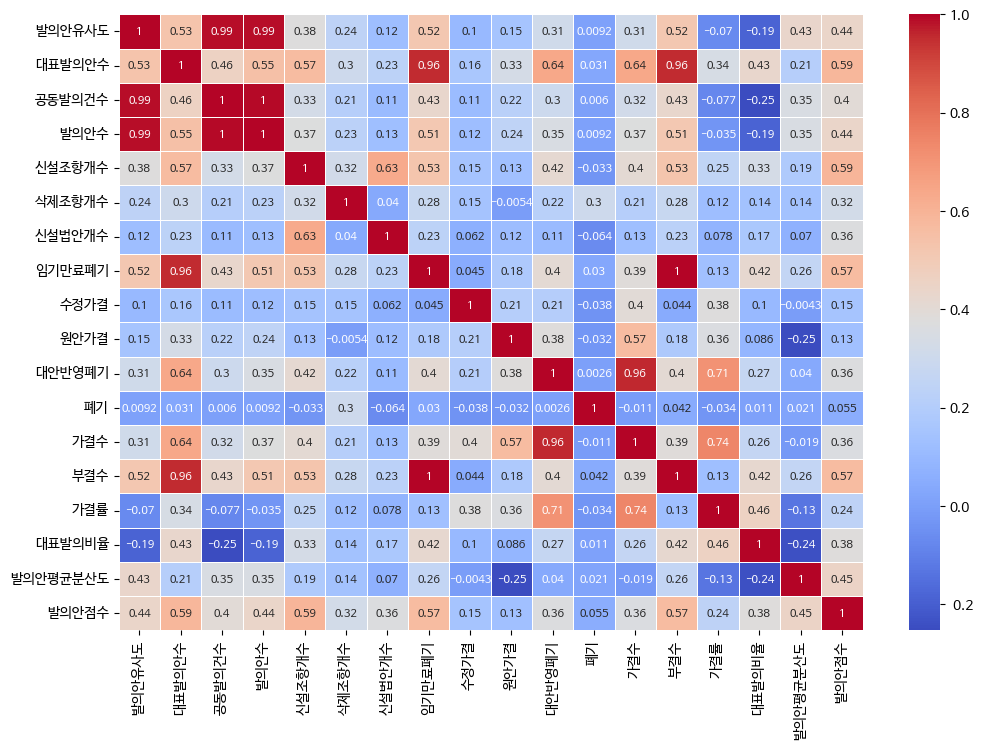

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumBarunGothic')

corr = name_df.corr()

plt.figure(figsize = (12,8))
# 히트맵 생성
sns.heatmap(corr,
            annot=True,
            cmap='coolwarm',
            annot_kws={"size": 8},
            linewidths=0.5)


plt.show()

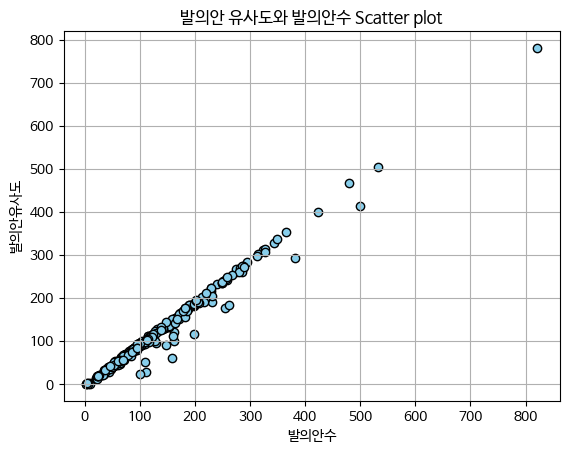

In [33]:
# 히스토그램 그리기
plt.scatter(x = name_df["발의안수"] ,y = name_df["발의안유사도"], color='skyblue', edgecolor='black')
plt.title('발의안 유사도와 발의안수 Scatter plot')
plt.xlabel('발의안수')
plt.ylabel('발의안유사도')
plt.grid(True)
plt.show()

> 발의안수와 발의안유사도의 상관관계가 매우 높음. 최종 입법평가모델에 사용하기 위해서는 발의안유사도를 발의안수로 나눈 발의안평균분산도를 사용해야함. 발의안유사도는 대표발의안과 공동발의안의 키워드를 모두 이용했기 때문에 발의안수로 나누는게 올바르다.

<ipython-input-34-a34e711755b5>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(name_df[col], ax = axes[i], shade = True)
<ipython-input-34-a34e711755b5>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(name_df[col], ax = axes[i], shade = True)
<ipython-input-34-a34e711755b5>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(name_df[col], ax = axes[i], shade = True)
<ipython-input-34-a34e711755b5>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(name_df[col], ax = axes[i], shade = True)
<ipython-inp

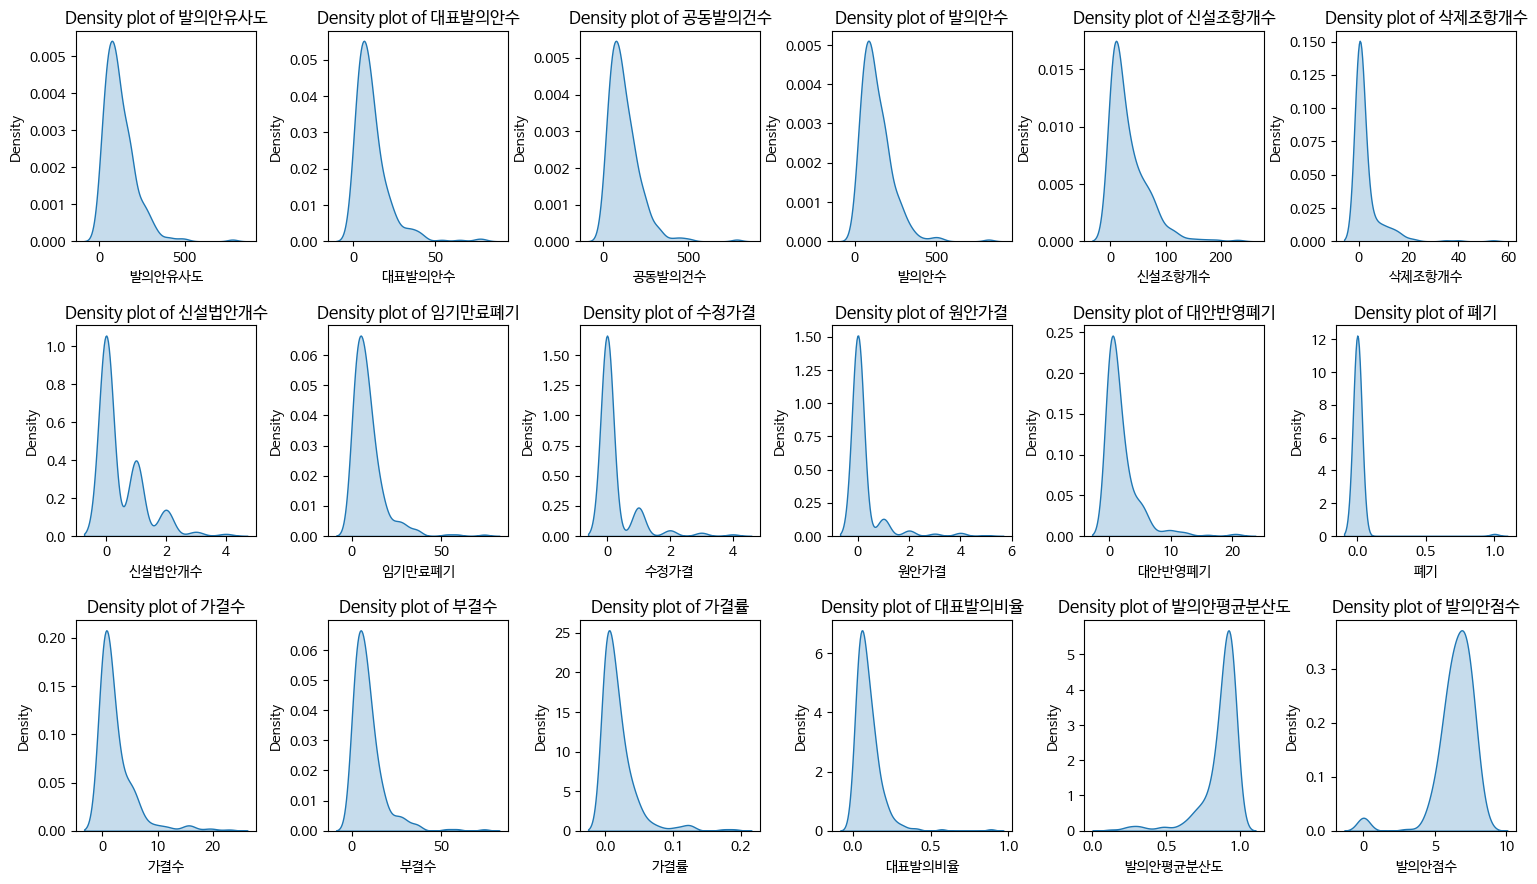

In [34]:
# density plot
import numpy as np

fig, axes = plt.subplots(3,6, figsize = (18,10))

axes = axes.flatten()

for i, col in enumerate(name_df.columns) :
    sns.kdeplot(name_df[col], ax = axes[i], shade = True)
    axes[i].set_title(f"Density plot of {col}")

# 서브플롯 간의 간격 조정
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# 그래프 출력
plt.show()

In [35]:
#발의안유사도 클러스터링 및 시각화

from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 클러스터링 시각화
def visual(new_df,kmeans) :
    pca = PCA(n_components=2) #2차원으로 축소
    pc = pca.fit_transform(new_df)
    p_df = pd.DataFrame(data=pc, columns=['main1', 'main2'])

    plt.scatter(p_df.iloc[kmeans.labels_ == 0,0],
                p_df.iloc[kmeans.labels_ == 0,1], s = 10, c = 'red', label = 'clustering1')
    plt.scatter(p_df.iloc[kmeans.labels_ == 1,0],
                p_df.iloc[kmeans.labels_ == 1,1], s = 10, c = 'blue', label = 'clustering2')
    plt.scatter(p_df.iloc[kmeans.labels_ == 2,0],
                p_df.iloc[kmeans.labels_ == 2,1], s = 10, c = 'green', label = 'clustering3')

    plt.legend()
    plt.show()

def cluster(documents):
    X, vectorizer = vectorize(documents)  # vectorize() 함수에서 반환된 X와 vectorizer 객체를 튜플로 받음
    best_n_clusters = find_elbow_point(X) # n값

    #K-means fitting
    kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
    kmeans.fit(X)

    #클러스터링 시각화
    x = X.toarray()
    visual(x,kmeans)

    #Elbow 시각화
    visualizer = KElbowVisualizer(kmeans, k=(1,6), timings=False)
    visualizer.fit(x)
    visualizer.show()


    # 각 클러스터의 중심 단어 가져오기
    cluster_centers = kmeans.cluster_centers_
    feature_names = vectorizer.get_feature_names_out()  # vectorizer 객체에서 특성 이름 가져오기
    cluster_keywords = []
    for center in cluster_centers:
        top_indices = center.argsort()[-10:]  # 클러스터 중심 벡터에서 상위 10개의 인덱스 가져오기
        keywords = [feature_names[i] for i in top_indices]  # 해당 인덱스에 해당하는 단어 가져오기
        cluster_keywords.append(keywords)

    return kmeans.inertia_, cluster_keywords
    #이때 inertia는 군집 내의 거리를 의미. 국회의원은 본인이 속해있는 상임위원회가 있으므로 발의하는 큰 주제는 비슷할 것이라고 판단하여,
    #군집 간의 거리보다 군집 내의 거리가 더 중요하므로, inertia 값을 반환함

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


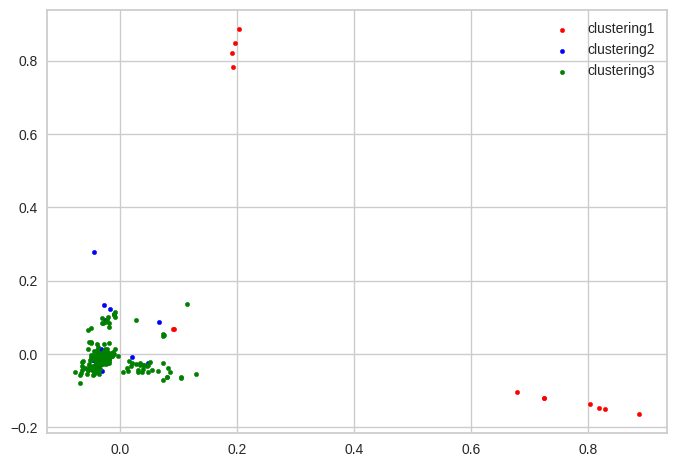

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

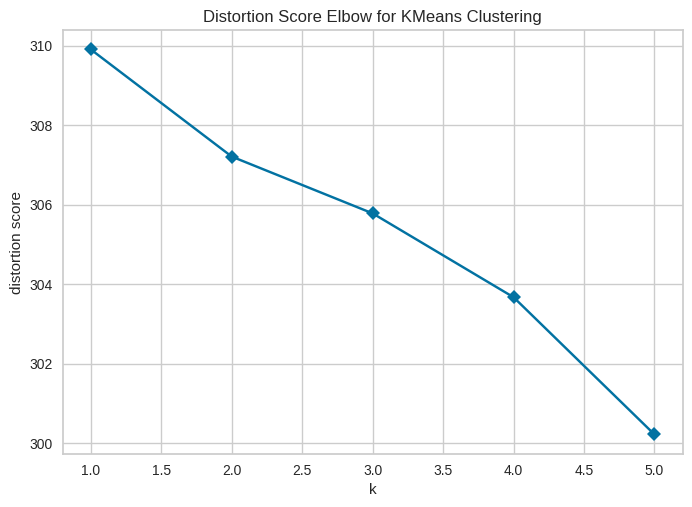

In [36]:
result = {}

name = "서영교"

# 국회의원의 모든 발의안 키워드 가져옴
doc = name_dict[name]

if len(doc) > 1:
    avg_inertia, keywords = cluster(doc)  # cluster() 함수에서 반환된 키워드를 받음
    result[name] = {'avg_inertia': avg_inertia, 'keywords': keywords}  # 결과를 딕셔너리로 저장
else:
    result[name] = {'avg_inertia': 0, 'keywords': []}  # 문서가 하나밖에 없는 경우 클러스터링 불가


In [37]:
#클러스터링 결과 반환
result_value = result.values()
inertia = list(result_value)[0]["avg_inertia"]
keywords = sum(list(result_value)[0]["keywords"],[])

print(f"name : {name}")
print(f"inertia : {inertia }")
print(f"keywords : {keywords}")

name : 서영교
inertia : 300.22131901541803
keywords : ['관리', '보험', '설립', '건강', '위반', '기여', '마련', '의료', '근거', '국민', '정보', '동의', '학생', '사유', '활동', '이용', '피해', '자료', '관리', '안전', '현실', '기준', '규모', '의사', '결정', '주요', '운용', '투명', '기금', '과정', '국가', '교육', '기부', '지정', '개발', '설치', '자치', '단체', '시설', '지방', '결정', '사항', '법률', '학교', '피해자', '적용', '이상', '범죄', '보호', '교육']


##최종입법평가모델

In [38]:
"""
최종 국회의원 데이터셋 만들기
-> 국회의원 데이터셋에서 신설법안개수, 대표발의비율, 가결수, 발의안점수, 발의안평균분산도 총 6개 컬럼을 사용해서 입법평가모델 제작
"""

col = [ "신설법안개수", "대표발의비율", "가결수", "발의안점수", "발의안평균분산도"]
final  = name_df.loc[:,col]

In [39]:
#최종점수파일 가져오기
final_score = pd.read_csv("최종점수.csv")
final_score.set_index(keys = "국회의원명", inplace = True, drop = True)
final["최종점수"] = final_score

In [40]:
#최종입법평가모델 확인
final

,신설법안개수,대표발의비율,가결수,발의안점수,발의안평균분산도,최종점수
국회의원명,,,,,,
강길부,1,0.037736,1,6.08,0.804855,31.773387
강병원,0,0.115646,5,7.05,0.912369,33.224978
강석진,2,0.155405,15,7.19,0.612089,36.253535
강석호,2,0.067485,5,7.13,0.751805,33.909102
강창일,0,0.108333,3,7.04,0.936200,32.538225
...,...,...,...,...,...,...
홍익표,0,0.151163,9,6.96,0.876207,33.865545
홍일표,1,0.171429,6,7.08,0.810369,34.580139
홍철호,0,0.178947,1,7.15,0.875996,32.563782
